#**Ten Categories**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

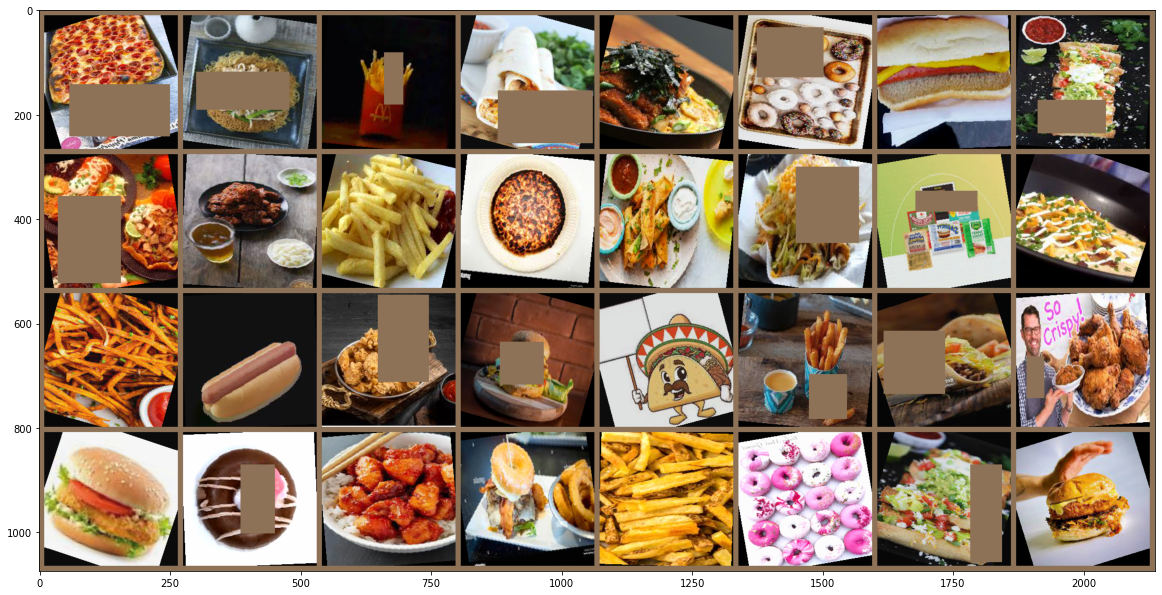

In [4]:
import os
import numpy as np
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from  torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Other constants
num_classes = 10
model_save_name = '10_categories_checkpoint.pth'
path = F"/content/drive/My Drive/{model_save_name}" 
ROOT_PATH = '/content/drive/MyDrive/comp6721-project/datasets/dataset-10'
training_path = f'{ROOT_PATH}/train'
validation_path = f'{ROOT_PATH}/val'
evaluation_path = f'{ROOT_PATH}/test'

# Model training constants
batch_size = 32
num_epochs = 15

# Loss function & optimizer constants
lr = 0.001
momentum = 0.9
step_size = 5
gamma = 0.1

# Image constants
image_size = 256
mean = [0.554, 0.450, 0.343]
std = [0.231, 0.241, 0.241]

# Transform
main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.RandomErasing()
])

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)
in_features = int(model.fc.in_features)
model.fc = nn.Linear(in_features, num_classes, device)
model = model.to(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Dataset
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
evaluation_dataset = datasets.ImageFolder(evaluation_path, transform=main_transform)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
evaluation_dataloader = DataLoader(evaluation_dataset, batch_size = batch_size, shuffle=False, num_workers=2)

# Image samples
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

## Training

In [3]:
# Training
%%time

losses = []
accuracy = []

for epoch in range(num_epochs):
    for i , (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        #train model
        outputs = model(inputs)
        
        #criterion
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #update parameters
        optimizer.step()
        
        #accuracy
        _, predicted = torch.max(outputs.data, 1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()
        accuracy.append(correct / total)

        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f, Accuracy: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, loss.item(), correct / total))


Epoch [ 1/15], Step [ 50/468], Loss: 2.2200, Accuracy: 0.2812


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [ 1/15], Step [100/468], Loss: 2.2294, Accuracy: 0.1562
Epoch [ 1/15], Step [150/468], Loss: 2.2572, Accuracy: 0.1250
Epoch [ 1/15], Step [200/468], Loss: 2.1094, Accuracy: 0.2500
Epoch [ 1/15], Step [250/468], Loss: 1.9560, Accuracy: 0.2812


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [ 1/15], Step [300/468], Loss: 2.0559, Accuracy: 0.3125
Epoch [ 1/15], Step [350/468], Loss: 2.1196, Accuracy: 0.2500
Epoch [ 1/15], Step [400/468], Loss: 1.8567, Accuracy: 0.2812
Epoch [ 1/15], Step [450/468], Loss: 1.9683, Accuracy: 0.2500
Epoch [ 2/15], Step [ 50/468], Loss: 1.9477, Accuracy: 0.2500
Epoch [ 2/15], Step [100/468], Loss: 2.3068, Accuracy: 0.1875


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [ 2/15], Step [150/468], Loss: 1.9967, Accuracy: 0.2812
Epoch [ 2/15], Step [200/468], Loss: 1.7342, Accuracy: 0.3438
Epoch [ 2/15], Step [250/468], Loss: 1.7538, Accuracy: 0.3750
Epoch [ 2/15], Step [300/468], Loss: 1.9250, Accuracy: 0.3750
Epoch [ 2/15], Step [350/468], Loss: 1.8394, Accuracy: 0.5000
Epoch [ 2/15], Step [400/468], Loss: 1.5605, Accuracy: 0.4375
Epoch [ 2/15], Step [450/468], Loss: 1.8338, Accuracy: 0.4062


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [ 3/15], Step [ 50/468], Loss: 1.5181, Accuracy: 0.4688
Epoch [ 3/15], Step [100/468], Loss: 1.7587, Accuracy: 0.5312
Epoch [ 3/15], Step [150/468], Loss: 1.6806, Accuracy: 0.5000
Epoch [ 3/15], Step [200/468], Loss: 1.4621, Accuracy: 0.5312
Epoch [ 3/15], Step [250/468], Loss: 1.6810, Accuracy: 0.4375
Epoch [ 3/15], Step [300/468], Loss: 1.6928, Accuracy: 0.4062
Epoch [ 3/15], Step [350/468], Loss: 1.4845, Accuracy: 0.4375
Epoch [ 3/15], Step [400/468], Loss: 1.7115, Accuracy: 0.4375
Epoch [ 3/15], Step [450/468], Loss: 1.7489, Accuracy: 0.4375
Epoch [ 4/15], Step [ 50/468], Loss: 1.4159, Accuracy: 0.5625
Epoch [ 4/15], Step [100/468], Loss: 1.5972, Accuracy: 0.4688
Epoch [ 4/15], Step [150/468], Loss: 1.6143, Accuracy: 0.5000


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [ 4/15], Step [200/468], Loss: 1.7133, Accuracy: 0.5000
Epoch [ 4/15], Step [250/468], Loss: 1.0713, Accuracy: 0.6562
Epoch [ 4/15], Step [300/468], Loss: 1.4963, Accuracy: 0.6250
Epoch [ 4/15], Step [350/468], Loss: 1.5204, Accuracy: 0.5000
Epoch [ 4/15], Step [400/468], Loss: 1.5352, Accuracy: 0.5625
Epoch [ 4/15], Step [450/468], Loss: 1.7737, Accuracy: 0.5000


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [ 5/15], Step [ 50/468], Loss: 1.3524, Accuracy: 0.5938
Epoch [ 5/15], Step [100/468], Loss: 1.4280, Accuracy: 0.5312
Epoch [ 5/15], Step [150/468], Loss: 1.4245, Accuracy: 0.5938


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [ 5/15], Step [200/468], Loss: 1.5109, Accuracy: 0.4375
Epoch [ 5/15], Step [250/468], Loss: 1.7871, Accuracy: 0.3438
Epoch [ 5/15], Step [300/468], Loss: 1.2191, Accuracy: 0.5938
Epoch [ 5/15], Step [350/468], Loss: 1.5243, Accuracy: 0.4375
Epoch [ 5/15], Step [400/468], Loss: 1.3052, Accuracy: 0.5938
Epoch [ 5/15], Step [450/468], Loss: 1.5756, Accuracy: 0.4688
Epoch [ 6/15], Step [ 50/468], Loss: 1.3276, Accuracy: 0.5312


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [ 6/15], Step [100/468], Loss: 1.3490, Accuracy: 0.6250


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [ 6/15], Step [150/468], Loss: 1.0227, Accuracy: 0.6875
Epoch [ 6/15], Step [200/468], Loss: 1.8065, Accuracy: 0.4688
Epoch [ 6/15], Step [250/468], Loss: 1.3682, Accuracy: 0.6562
Epoch [ 6/15], Step [300/468], Loss: 1.5522, Accuracy: 0.5000
Epoch [ 6/15], Step [350/468], Loss: 1.3573, Accuracy: 0.5938
Epoch [ 6/15], Step [400/468], Loss: 1.2731, Accuracy: 0.5938
Epoch [ 6/15], Step [450/468], Loss: 1.2915, Accuracy: 0.5938
Epoch [ 7/15], Step [ 50/468], Loss: 1.3661, Accuracy: 0.5312
Epoch [ 7/15], Step [100/468], Loss: 1.5498, Accuracy: 0.5000
Epoch [ 7/15], Step [150/468], Loss: 1.3656, Accuracy: 0.5625
Epoch [ 7/15], Step [200/468], Loss: 1.1467, Accuracy: 0.5938


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [ 7/15], Step [250/468], Loss: 1.3489, Accuracy: 0.5625
Epoch [ 7/15], Step [300/468], Loss: 1.1635, Accuracy: 0.5312
Epoch [ 7/15], Step [350/468], Loss: 1.7324, Accuracy: 0.5000
Epoch [ 7/15], Step [400/468], Loss: 1.4030, Accuracy: 0.5625


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [ 7/15], Step [450/468], Loss: 1.1882, Accuracy: 0.6250
Epoch [ 8/15], Step [ 50/468], Loss: 1.0650, Accuracy: 0.7188
Epoch [ 8/15], Step [100/468], Loss: 0.9490, Accuracy: 0.6875


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [ 8/15], Step [150/468], Loss: 1.4262, Accuracy: 0.5312
Epoch [ 8/15], Step [200/468], Loss: 1.4062, Accuracy: 0.5000
Epoch [ 8/15], Step [250/468], Loss: 0.8689, Accuracy: 0.7500
Epoch [ 8/15], Step [300/468], Loss: 1.2257, Accuracy: 0.5938
Epoch [ 8/15], Step [350/468], Loss: 1.4307, Accuracy: 0.5312
Epoch [ 8/15], Step [400/468], Loss: 1.1433, Accuracy: 0.6250
Epoch [ 8/15], Step [450/468], Loss: 1.1723, Accuracy: 0.6250


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [ 9/15], Step [ 50/468], Loss: 1.2639, Accuracy: 0.5938
Epoch [ 9/15], Step [100/468], Loss: 1.3941, Accuracy: 0.4062


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [ 9/15], Step [150/468], Loss: 1.3061, Accuracy: 0.4062
Epoch [ 9/15], Step [200/468], Loss: 1.2181, Accuracy: 0.5312
Epoch [ 9/15], Step [250/468], Loss: 1.2983, Accuracy: 0.5938
Epoch [ 9/15], Step [300/468], Loss: 1.2851, Accuracy: 0.5625
Epoch [ 9/15], Step [350/468], Loss: 1.0856, Accuracy: 0.6562
Epoch [ 9/15], Step [400/468], Loss: 1.1495, Accuracy: 0.5938
Epoch [ 9/15], Step [450/468], Loss: 1.3418, Accuracy: 0.4375


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10/15], Step [ 50/468], Loss: 1.2454, Accuracy: 0.6875
Epoch [10/15], Step [100/468], Loss: 0.8669, Accuracy: 0.6250
Epoch [10/15], Step [150/468], Loss: 0.8888, Accuracy: 0.5938
Epoch [10/15], Step [200/468], Loss: 0.9443, Accuracy: 0.6875
Epoch [10/15], Step [250/468], Loss: 1.1539, Accuracy: 0.6250
Epoch [10/15], Step [300/468], Loss: 0.9869, Accuracy: 0.6562
Epoch [10/15], Step [350/468], Loss: 1.5943, Accuracy: 0.4375


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10/15], Step [400/468], Loss: 1.2013, Accuracy: 0.6250
Epoch [10/15], Step [450/468], Loss: 0.9914, Accuracy: 0.6875
Epoch [11/15], Step [ 50/468], Loss: 0.9908, Accuracy: 0.7188
Epoch [11/15], Step [100/468], Loss: 0.8107, Accuracy: 0.7188
Epoch [11/15], Step [150/468], Loss: 0.9357, Accuracy: 0.7500


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [11/15], Step [200/468], Loss: 0.8770, Accuracy: 0.7812
Epoch [11/15], Step [250/468], Loss: 0.9151, Accuracy: 0.6250
Epoch [11/15], Step [300/468], Loss: 1.2064, Accuracy: 0.5625


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [11/15], Step [350/468], Loss: 0.8177, Accuracy: 0.7188
Epoch [11/15], Step [400/468], Loss: 1.6238, Accuracy: 0.5312
Epoch [11/15], Step [450/468], Loss: 0.8133, Accuracy: 0.6875
Epoch [12/15], Step [ 50/468], Loss: 1.1294, Accuracy: 0.6250
Epoch [12/15], Step [100/468], Loss: 0.9693, Accuracy: 0.6562
Epoch [12/15], Step [150/468], Loss: 1.1532, Accuracy: 0.5000
Epoch [12/15], Step [200/468], Loss: 1.1106, Accuracy: 0.7188


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [12/15], Step [250/468], Loss: 0.7688, Accuracy: 0.8438
Epoch [12/15], Step [300/468], Loss: 1.1171, Accuracy: 0.6250
Epoch [12/15], Step [350/468], Loss: 1.1825, Accuracy: 0.6250
Epoch [12/15], Step [400/468], Loss: 1.2131, Accuracy: 0.6250


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [12/15], Step [450/468], Loss: 0.6998, Accuracy: 0.7812


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [13/15], Step [ 50/468], Loss: 0.8207, Accuracy: 0.6875
Epoch [13/15], Step [100/468], Loss: 0.9473, Accuracy: 0.7812
Epoch [13/15], Step [150/468], Loss: 1.2891, Accuracy: 0.6250


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [13/15], Step [200/468], Loss: 0.8897, Accuracy: 0.6250
Epoch [13/15], Step [250/468], Loss: 1.1033, Accuracy: 0.5938
Epoch [13/15], Step [300/468], Loss: 0.8074, Accuracy: 0.7812
Epoch [13/15], Step [350/468], Loss: 1.1890, Accuracy: 0.7188
Epoch [13/15], Step [400/468], Loss: 0.9807, Accuracy: 0.6875
Epoch [13/15], Step [450/468], Loss: 0.7130, Accuracy: 0.7500


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [14/15], Step [ 50/468], Loss: 0.8600, Accuracy: 0.7188


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [14/15], Step [100/468], Loss: 1.2727, Accuracy: 0.5938
Epoch [14/15], Step [150/468], Loss: 0.9904, Accuracy: 0.6562
Epoch [14/15], Step [200/468], Loss: 1.1390, Accuracy: 0.6875
Epoch [14/15], Step [250/468], Loss: 1.0287, Accuracy: 0.5938
Epoch [14/15], Step [300/468], Loss: 0.6950, Accuracy: 0.7188
Epoch [14/15], Step [350/468], Loss: 0.8358, Accuracy: 0.6562
Epoch [14/15], Step [400/468], Loss: 0.8343, Accuracy: 0.7812
Epoch [14/15], Step [450/468], Loss: 0.8493, Accuracy: 0.7500


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [15/15], Step [ 50/468], Loss: 0.7547, Accuracy: 0.7812
Epoch [15/15], Step [100/468], Loss: 0.9888, Accuracy: 0.5312
Epoch [15/15], Step [150/468], Loss: 0.8169, Accuracy: 0.7500
Epoch [15/15], Step [200/468], Loss: 0.9748, Accuracy: 0.5000
Epoch [15/15], Step [250/468], Loss: 0.8716, Accuracy: 0.7500
Epoch [15/15], Step [300/468], Loss: 0.9726, Accuracy: 0.7188
Epoch [15/15], Step [350/468], Loss: 0.7094, Accuracy: 0.8125


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [15/15], Step [400/468], Loss: 1.0180, Accuracy: 0.6562
Epoch [15/15], Step [450/468], Loss: 0.7888, Accuracy: 0.7500
CPU times: user 9min 57s, sys: 1min 4s, total: 11min 1s
Wall time: 1h 2min 27s


## Save model

In [4]:
from google.colab import files


torch.save(model.state_dict(), path)


## Valuation

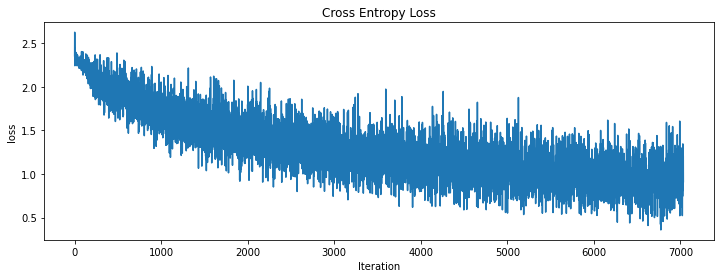

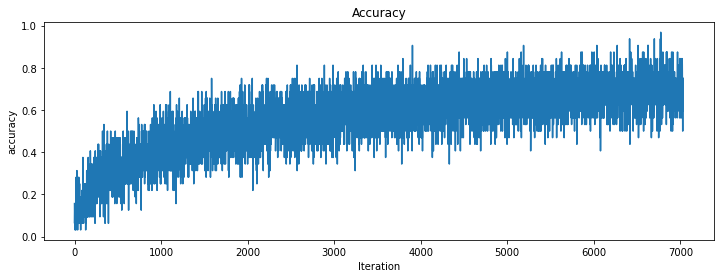

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train accuracy: 65.25
Test accuracy: 57.13
Confusion Matrix:
[[ 57   0  11   0   1   0   0   2   7  22]
 [  1 136   5   6  14   2   0  12   6  18]
 [  1   3  94   0   1   0   0   0   0   1]
 [  1   5  10 160   6   1   2   5   6   4]
 [  2   1  19   1  71   0   0   1   2   3]
 [  7   7  18  11  16  70   2   6  44  19]
 [  3   1  59   1   9   2  79  10  16  20]
 [  7  12  11   3   4   5   1 106  12  39]
 [  1   0   7   0   1   0   1   2  58  30]
 [  1   0  10   3   8   0   0   6  46  26]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.57      0.63       100
           1       0.82      0.68      0.75       200
           2       0.39      0.94      0.55       100
           3       0.86      0.80      0.83       200
           4       0.54      0.71      0.61       100
           5       0.88      0.35      0.50       200
           6       0.93      0.40      0.55       200
           7       0.71      0.53      0.61       20

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(accuracy)
plt.xlabel('Iteration')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.show()


def evaluate_model(title, model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())

    print('{title} accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset), title=title))
    if title.lower() == "test":
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Compute the precision, recall, and F1 score
        report = classification_report(y_true, y_pred)
        print('Confusion Matrix:')
        print(cm)
        print('Classification Report:')
        print(report)


evaluate_model("Train", model, train_dataloader, device)
evaluate_model("Test", model, evaluation_dataloader, device)

## t-SNE

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


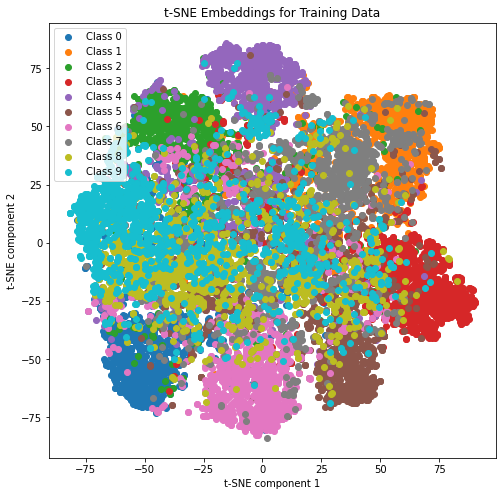

CPU times: user 3min 1s, sys: 5.67 s, total: 3min 7s
Wall time: 54min 42s


In [6]:
%%time
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

def compute_tsne(model, dataloader):
    """
    Computes t-SNE embeddings for the given model and dataloader.
    """
    # Set model to evaluation mode
    model.eval()
        
    # Get the features from the last layer for all samples in the dataset
    features = []
    labels = []

    # Define a function to extract the features from the last layer
    # def get_features_hook(module, input, output):
    #     features.append(output.detach().cpu().numpy())

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # model.fc.register_forward_hook(get_features_hook)
            outputs = model(inputs)
            features.append(outputs.detach().cpu().numpy())
            labels.append(targets.detach().cpu().numpy())
    
    features = np.concatenate(features)
    labels = np.concatenate(labels)

    # Compute t-SNE embeddings
    tsne = TSNE(n_components=2, perplexity=30, random_state=0)
    embeddings = tsne.fit_transform(features)

    return embeddings, labels


train_embeddings, train_labels = compute_tsne(model, train_dataloader)
# Plot t-SNE embeddings for the training datasets
import matplotlib.pyplot as plt

# Plot t-SNE embeddings
plt.figure(figsize=(8,8))
for i in range(num_classes):
    plt.scatter(train_embeddings[train_labels==i,0], train_embeddings[train_labels==i,1], label=f'Class {i}')
plt.legend()
plt.title('t-SNE Embeddings for Training Data')
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

# Helper: Save/Load model

In [5]:
# Load model
from google.colab import files

state_dict = torch.load(path)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# Valuation loaded model
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(title, model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
            y_true.extend(targets.tolist())
            y_pred.extend(preds.tolist())

    print('{title} accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset), title=title))
    if title.lower() == "test":
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Compute the precision, recall, and F1 score
        report = classification_report(y_true, y_pred)
        print('Confusion Matrix:')
        print(cm)
        print('Classification Report:')
        print(report)


evaluate_model("Train", model, train_dataloader, device)
evaluate_model("Test", model, evaluation_dataloader, device)

Train accuracy: 78.16
Test accuracy: 76.01


NameError: ignored